# Model definition

Below is an implementation of the [LeNet](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) architecture for the MNIST dataset.

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

Fact checking!) Maybe were not so attentive and missed that we didn't turn CUDA

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

CUDA Available:  True


Of note: This notebook uses only a single GPU.
PyTorch can run models on several GPU, try to search how to specify several GPUs and create several devices.
model = Net().to(device)
model

## Master way

Or inspect code for training a model

In [7]:
import torch.optim as optim
train_loader = torch.utils.data.DataLoader(
                   datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([transforms.ToTensor(),])),
                   batch_size=128, shuffle=True)

criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epoch_num = 20

for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Remember a line with model.to(device)?
        # It moves a model to a GPU and PyTorch expects that
        # input data also will be on the GPU where the model resides
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Calculate the error between model predictins and actual labels
        loss = criterion(outputs, labels)
        
        # Initiate backward propagation
        loss.backward()
        
        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}: batch {i + 1}] loss: {running_loss / 200}')
            running_loss = 0.0

print('Finished Training')

  0%|          | 16384/9912422 [00:00<01:33, 106130.30it/s]

9920512it [00:00, 22147396.77it/s]                           


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


32768it [00:00, 319083.77it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:00, 5292248.25it/s]                           
8192it [00:00, 127029.64it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw
Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!
[Epoch 1: batch 200] loss: 2.303384546041489
[Epoch 1: batch 400] loss: 2.2937665462493895
[Epoch 2: batch 200] loss: 2.2570377480983734
[Epoch 2: batch 400] loss: 2.07907123029232
[Epoch 3: batch 200] loss: 1.3508539617061615
[Epoch 3: batch 400] loss: 1.0321911495923997
[Epoch 4: batch 200] loss: 0.8401314169168472
[Epoch 4: batch 400] loss: 0.768484505712986
[Epoch 5: batch 200] loss: 0.7086541709303856
[Epoch 5: batch 400] loss: 0.6567149890959263
[Epoch 6: batch 200] loss: 0.6153358618915081
[Epoch 6: batch 400] loss: 0.5968232147395611
[Epoch 7: batch 200] loss: 0.5755457104742527
[Epoch 7: batch 400] loss: 0.5391014856100083
[Epoch 8: batch 200] loss: 0.5344913145899772
[Epoch 8: batch 400] loss: 0.49288954317569733
[Epoch 9: batch 200] loss: 0.49392173618078233
[Epoch 9: batch 400] loss: 0.48002193227410317
[

Let's check how accurate is our network

In [8]:
data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=256)
# Prevent training
model.eval()

total_correct = 0
avg_loss = 0.0

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    output = model(inputs)
    avg_loss += criterion(output, labels).sum()
    
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad.
    # It detaches the output from the computational graph.
    # So no gradient will be backpropagated along this variable.
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()

avg_loss /= len(data_test)
avg_loss = avg_loss.detach().cpu().item()
accuracy = float(total_correct) / len(data_test)
print(f'Test Avg. Loss: {avg_loss}, Accuracy: {accuracy * 100}%')

# Save model state for re-use
my_awesome_model = 'my-lenet.pth'
torch.save(model.state_dict(), my_awesome_model)
# End of training code

Test Avg. Loss: 0.0004768944636452943, Accuracy: 96.23%


In [0]:
 # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist',
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)

Test function performs a full test step on the MNIST test set and reports a final accuracy.

For each sample in the test set, the function computes the gradient of the loss w.r.t the input data (data_grad),  creates a perturbed image with fgsm_attack (perturbed_data), then checks to see if the perturbed example is adversarial. 

# PRACTICUM TASK

1 - For each class select 10 images not from this class. Perform attack to move selected images to this class. for each class select image with highest confidence.
    
Best sample is the one with higher confidence.

2 - Try different epsilons for one selected class and collect the number of iterations required to achieve success

3* OPTIONAL - make attacks using a model trained on Cifar10 obtained from the previous task.

# Let's rock!

importing foolbox and torch



In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

If it's necessary - install foolbox

In [11]:
pip install foolbox

     |████████████████████████████████| 1.9MB 3.5MB/s 
     |████████████████████████████████| 460kB 52.0MB/s 
     |████████████████████████████████| 71kB 13.2MB/s 
  Created wheel for foolbox: filename=foolbox-2.3.0-cp36-none-any.whl size=1926239 sha256=779c71961443d697afff9890147e291288b66d084f60953a47e6f9be4ae2edec
  Stored in directory: /root/.cache/pip/wheels/3a/e4/a4/b6a9e61a9729c442383d774328091f69d9235268401a1c9524
Successfully built foolbox


In [0]:
import foolbox
from foolbox.models import PyTorchModel
from foolbox.attacks import L2BasicIterativeAttack, FGSM
from foolbox.criteria import Misclassification, ConfidentMisclassification, TargetClassProbability

Loader and criterion. We have chosen class of digit 2.

In [0]:
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=128, shuffle=True)

criterion = TargetClassProbability(2, 0.90)

Visualization if it is necessary.

Creating a dictionary, which has keys = digits and values are ten pictures, which contains these digits.

In [0]:
from collections import defaultdict
digit_images = defaultdict(list)
data, label = next(iter(loader))
# label = np.array(lebel)

for digit in range(10):
  i = 0
  while (len(digit_images[digit])) != 10 and i < len(data):
    if label[i] == digit:
      digit_images[digit].append(data[i][0])
    i += 1

Functions for adversarials

In [0]:
model.eval()
fb_model = PyTorchModel(
    model, 
    bounds=(-4, +4), 
    num_classes=10,
    channel_axis=1,
)
 
transform = transforms.Compose(
    [
        # resize image to 28 pixels in width and hight
        transforms.Resize((28, 28)),
        
        # transorm "Image" object to "tensor" onject. Used when working with PIL.Image
        transforms.ToTensor(),
        
        # Normalize image per chanel
        # transforms.Normalize(
        #     mean=[0.485, 0.456, 0.406],
        #     std=[0.229, 0.224, 0.225]
        # )
    ]
)

In [0]:
from PIL import Image

def restore_image(image):
    # Move chanel axis [3, 299, 299] -> [299, 299, 3]
    new_image = np.rollaxis(np.rollaxis((image), 2), 2)
    
    # Multiply by std and add mean
    # new_image = (new_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    
    # Move from range 0-1 to the range 0-255
    new_image = new_image * 255
    
    # Make sure to remove all values that lower that 0 or higher than 255
    # as it not valid images
    new_image = np.clip(new_image, 0, 255)
    
    # Put image to the "byte" format. 
    # That`s required by PIL.Image to be abble to restore image from numpy array
    new_image = new_image.astype(np.uint8)
    return new_image[:,:,0]

In [0]:
def generate_adversarial(foolbox_model, attack, selected_criterion, image):
    attack = attack(
        model=foolbox_model,
        criterion=selected_criterion
    )
    normalized_image = image.unsqueeze(0).to(device)
    ########### I added  another unsqueeze, because it caused an error ########
    normalized_image = normalized_image.unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    
    normalazed_input_numpy = normalized_image.cpu().numpy()
    predicted_labels = np.array([int(predicted_class)])

    new_images = attack(normalazed_input_numpy, labels=predicted_labels)
    
    restored_numpy_array = restore_image(new_images[0])
    restored_image = Image.fromarray(restored_numpy_array)
    return restored_image

def print_prediction(image, label):
  normalized_image = transform(image).unsqueeze(0).to(device)
  # print(normalized_image.size())
  # normalized_image = normalized_image.unsqueeze(0).to(device)
  prediction = model(normalized_image)[0]
  predicted_class = prediction.argmax(-1).cpu().numpy()
  probability = torch.softmax(prediction, -1)[predicted_class] * 100
  print(f"Predicted class {int(predicted_class)} : real {label}")
  print(f"Probability: {probability:.3f}")
  return probability


#Attacking

In [47]:
# pic = digit_images[j][1]
cnt = 0
predics = np.zeros(10)
examples = []
plt.figure(figsize=(20,20))
for digit in range(10):
  for j in range(10):
    if j == digit:
      pass
    else:
      adv_image = generate_adversarial(
          fb_model, 
          L2BasicIterativeAttack,
          TargetClassProbability(digit, 0.95), 
          digit_images[j][1]
      )
      a = print_prediction(adv_image, j)
      if predics[digit] <= a:
        predics[digit] = a
        pic = initial_image
  examples.append(pic)

# print_prediction(adv_image, 5)
# initial_image = adv_image.resize((150, 150))
# initial_image


Predicted class 0 : real 1
Probability: 84.875
Predicted class 0 : real 2
Probability: 79.707
Predicted class 0 : real 3
Probability: 86.019
Predicted class 0 : real 4
Probability: 67.955
Predicted class 0 : real 5
Probability: 75.046
Predicted class 0 : real 6
Probability: 76.025
Predicted class 0 : real 7
Probability: 75.271
Predicted class 0 : real 8
Probability: 79.879
Predicted class 0 : real 9
Probability: 78.643
Predicted class 1 : real 0
Probability: 89.757
Predicted class 1 : real 2
Probability: 76.360
Predicted class 1 : real 3
Probability: 56.129
Predicted class 1 : real 4
Probability: 62.599
Predicted class 1 : real 5
Probability: 79.797
Predicted class 6 : real 6
Probability: 79.021
Predicted class 1 : real 7
Probability: 88.770
Predicted class 1 : real 8
Probability: 55.656
Predicted class 1 : real 9
Probability: 78.143
Predicted class 2 : real 0
Probability: 81.946
Predicted class 2 : real 1
Probability: 86.925
Predicted class 2 : real 3
Probability: 79.544
Predicted cla

<Figure size 1440x1440 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


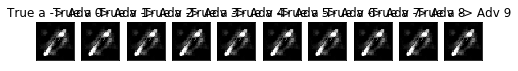

In [49]:
cnt = 0
plt.figure(figsize=(8,10))

# for i in range(10):
for j in range(len(examples)):
    cnt += 1
    plt.subplot(10,len(examples),cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        # plt.ylabel("Eps: {}".format(10), fontsize=14)
        pass
    # orig, adv, ex = examples[i][j]
    plt.title("True {} -> Adv {}".format('a', j))
    plt.imshow(examples[j], cmap="gray")
        
plt.tight_layout()
plt.show()